#  Group assignment


In [1]:
#Importing libraries
#Importing libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
    matthews_corrcoef, precision_score, confusion_matrix, make_scorer
import seaborn as sns
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [2]:
df = pd.read_csv('AUTO_LOANS_DATA.csv', sep = ';')

In [3]:
df.head()

,REPORTING_DATE,ACCOUNT_NUMBER,CUSTOMER_ID,PROGRAM_NAME,LOAN_OPEN_DATE,EXPECTED_CLOSE_DATE,ORIGINAL_BOOKED_AMOUNT,OUTSTANDING,BUCKET,SEX,CUSTOMER_OPEN_DATE,BIRTH_DATE,PROFESSION,CAR_TYPE
0,2016-01-31,1,1,Auto Loans 50% Down Payment - Employed,2015-11-25,2020-11-03,91000.0,88223.40,0,M,2015-10-27,1986-03-24,EMPLOYEE,KIA
1,2016-01-31,2,2,Pick Up and Small Trucks,2015-12-08,2017-12-03,35000.0,33714.82,0,M,2015-11-29,1985-08-18,EMPLOYEE,CARRY
2,2016-01-31,3,3,Auto Loans 40% Down Payment - Employed,2016-01-12,2021-01-03,52500.0,52500.00,0,F,2015-12-28,1985-07-02,HOUSEWIFE,CHEVROLET
3,2016-01-31,4,4,Auto Loans 30% Down Payment - Self Employed,2015-11-23,2019-10-03,103000.0,99054.45,0,M,2015-10-21,1979-01-01,Shop Owner,MITSUBISHI
4,2016-01-31,5,5,Auto Loans 30% Down Payment - Self Employed,2015-11-23,2018-11-03,94250.0,89450.17,0,M,2015-11-02,1977-01-20,Shop Owner,SEAT


In [4]:
# conda install -c conda-forge missingno

In [5]:
import missingno as msno

In [6]:
#Inserting and readingg the data (excel file)
#df = pd.read_excel("AUTO_LOANS_DATA.xlsx")
#df

## 1. **PENDING** - Missing not at random analysis -  Analyzing missing values

<AxesSubplot:>

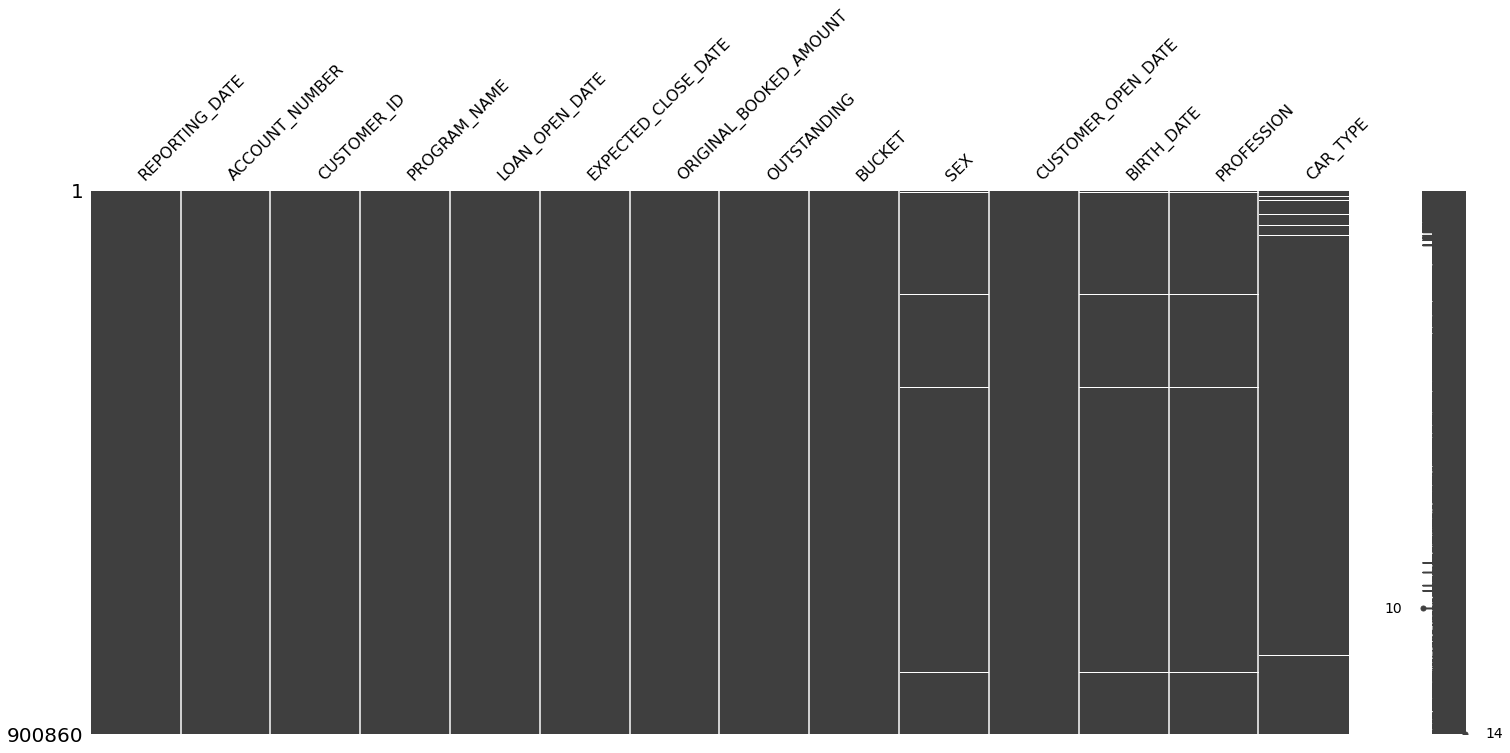

In [7]:
#Visualize the distribution of the missing values
msno.matrix(df)


In [8]:
null_columns=df.columns[df.isnull().any()]
print(df[null_columns].isnull().sum())
print(df[df.isnull().any(axis=1)][null_columns].head())

SEX            4528
BIRTH_DATE     4533
PROFESSION     5558
CAR_TYPE      11518
dtype: int64
     SEX  BIRTH_DATE     PROFESSION  CAR_TYPE
11   NaN         NaN            NaN  MERCEDES
61     M  1972-08-17         DOCTOR       NaN
117    M  1986-02-20         DRIVER       NaN
118    M  1967-03-24  Company Owner       NaN
143    M  1982-06-23     Contractor       NaN


## **1.** Initial steps

### **1.1.** Changing the name of the columns to lower case

In [9]:
print(list(df.columns))

['REPORTING_DATE', 'ACCOUNT_NUMBER', 'CUSTOMER_ID', 'PROGRAM_NAME', 'LOAN_OPEN_DATE', 'EXPECTED_CLOSE_DATE', 'ORIGINAL_BOOKED_AMOUNT', 'OUTSTANDING', 'BUCKET', 'SEX', 'CUSTOMER_OPEN_DATE', 'BIRTH_DATE', 'PROFESSION', 'CAR_TYPE']


In [10]:
#We want to transform the name of all the columns to lower case
df.rename(columns=lambda x: x.lower(), inplace=True)

In [11]:
print(list(df.columns))

['reporting_date', 'account_number', 'customer_id', 'program_name', 'loan_open_date', 'expected_close_date', 'original_booked_amount', 'outstanding', 'bucket', 'sex', 'customer_open_date', 'birth_date', 'profession', 'car_type']


### **1.2.** Removing duplicate records

In [12]:
#Locate the entire duplicated rows. Result = 0
duplicate_rows_df = df[df.duplicated()]
print('number of duplicate rows: ', duplicate_rows_df.shape)

number of duplicate rows:  (0, 14)


In [13]:
#Check for duplicate rows based on ACCOUNT_NUMBER and CUSTOMER_ID
duplicate_rows_df = df[df.duplicated(subset=['account_number', 'customer_id'])]
print('number of duplicate rows: ', duplicate_rows_df.shape)
duplicate_rows_df.sort_values(['customer_id', 'reporting_date'], ascending=True, inplace = True)


number of duplicate rows:  (861263, 14)


C:\Users\aaljeshi\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
# Drop duplicates and keep only last opened loan per account 

print("\n old shape: ",  df.shape) # Confirm original dataframe shape
df = df.sort_values(by="reporting_date").drop_duplicates(subset=["account_number", 'customer_id'], keep="last") # drop duplicates
print("\n new shape: ",  df.shape) # Confirm dataframe reduction


 old shape:  (900860, 14)

 new shape:  (39597, 14)


In [15]:
df.head()

,reporting_date,account_number,customer_id,program_name,loan_open_date,expected_close_date,original_booked_amount,outstanding,bucket,sex,customer_open_date,birth_date,profession,car_type
15639,2016-01-31,15640,15378,Auto Loans 40% Down Payment - Self Employed,2013-01-02,2016-01-03,81600.0,0.0,0,M,2012-12-03,1969-02-19,Company Owner,NaN
15651,2016-01-31,15652,15390,Pick Up and Small Trucks,2013-11-25,2015-11-03,84000.0,0.0,0,M,2013-11-11,1984-02-18,Shop Owner,NaN
15582,2016-01-31,15583,15323,Auto Loans 30% Down Payment - Self Employed,2015-06-24,2020-06-03,113400.0,0.0,7,M,2015-04-29,1988-08-23,Shop Owner,NaN
15741,2016-01-31,15742,15477,Auto Loans 30% Down Payment - Employed,2015-01-22,2020-02-03,57750.0,0.0,0,M,2014-09-24,1975-11-01,EMPLOYEE,NaN
15689,2016-01-31,15690,15427,Auto Loans Special Deals,2012-01-30,2016-01-22,65600.0,0.0,0,M,2011-01-05,1985-12-18,EMPLOYEE,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39597 entries, 15639 to 900859
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   reporting_date          39597 non-null  object 
 1   account_number          39597 non-null  int64  
 2   customer_id             39597 non-null  int64  
 3   program_name            39597 non-null  object 
 4   loan_open_date          39597 non-null  object 
 5   expected_close_date     39597 non-null  object 
 6   original_booked_amount  39597 non-null  float64
 7   outstanding             39597 non-null  float64
 8   bucket                  39597 non-null  int64  
 9   sex                     39320 non-null  object 
 10  customer_open_date      39597 non-null  object 
 11  birth_date              39319 non-null  object 
 12  profession              39281 non-null  object 
 13  car_type                37295 non-null  object 
dtypes: float64(2), int64(3), object(9

### **1.3.** Binning the target variable ("bucket")

In [17]:
df['bucket'].value_counts()

0    34990
1     2073
7     1149
2      805
3      306
4      147
5       85
6       42
Name: bucket, dtype: int64

In [18]:
# The variable "bucket" indicates the number of unpaid installements at each reporting date. We have transformed
# this variable to dummy variables to indicate whether the user has had unpaid installments (1) or not(0).
bucket_replace = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
df = df.replace({'bucket': bucket_replace})

In [19]:
df['bucket'].value_counts()

0    34990
1     4607
Name: bucket, dtype: int64

## 2. Data Preparation

### **2.1**. Dealing with date columns

To deal with date columns, we decided to do the following:

1. Identify Date Columns
2. Convert them into date format
3. Calculate the time difference between the mentioned date and the date of the 4. report
5. All the dates will be in months except the age in years
6. Calculate the expected loan duration in terms of months (e.g. a 44 months loan or a 60 months loan...etc.)
7. Finally, drop the original date columns as they would be replaced by the duration columns

In [20]:
from datetime import datetime

#I am not chossing the 'REPORTING_DATE' columns as it is not helping our analysis
date_columns = ['loan_open_date', 'expected_close_date', 'customer_open_date', 'birth_date'  ]

# Assuming the report date is today's date
today_date = datetime.strptime('2019-09-01',"%Y-%m-%d") 


for col in date_columns:
    df[col] =  pd.to_datetime(df[col],format='%Y-%m-%d') 
    age_col = col.split('_')
    age_col = col[0:(len(col)-4)]
    age_col = ''.join(age_col)+'duration'
    df[age_col] = df[col].apply(lambda x: today_date.month - x.month + 12*(today_date.year - x.year))

    
df['age'] = (round(df['birth_duration']/12)).where(df['birth_duration'].notnull())


df['loan_expected_duration'] =  df['expected_close_date'].dt.month - df['loan_open_date'].dt.month + 12*(df['expected_close_date'].dt.year - df['loan_open_date'].dt.year)

df.drop(['birth_duration', 'reporting_date', 'loan_open_date', 'expected_close_date',  'birth_date', 'customer_open_date'], axis = 1, inplace = True)

In [21]:
df.head()

,account_number,customer_id,program_name,original_booked_amount,outstanding,bucket,sex,profession,car_type,loan_open_duration,expected_close_duration,customer_open_duration,age,loan_expected_duration
15639,15640,15378,Auto Loans 40% Down Payment - Self Employed,81600.0,0.0,0,M,Company Owner,NaN,80,44,81,51.0,36
15651,15652,15390,Pick Up and Small Trucks,84000.0,0.0,0,M,Shop Owner,NaN,70,46,70,36.0,24
15582,15583,15323,Auto Loans 30% Down Payment - Self Employed,113400.0,0.0,1,M,Shop Owner,NaN,51,-9,53,31.0,60
15741,15742,15477,Auto Loans 30% Down Payment - Employed,57750.0,0.0,0,M,EMPLOYEE,NaN,56,-5,60,44.0,61
15689,15690,15427,Auto Loans Special Deals,65600.0,0.0,0,M,EMPLOYEE,NaN,92,44,104,34.0,48


In [22]:
from RiskDataframe import RiskDataframe
RiskDataframe.missing_not_at_random(df)

C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:97: RuntimeWarning: invalid value encountered in longlong_scalars
  condition = (test_rows - not_missing)/test_rows


Missing Not at Random Report -  ['sex', 'profession', 'age'] variables seem Missing Not at Random, there for we recommend:


Thin File Segment Variables:  ['account_number', 'customer_id', 'program_name', 'original_booked_amount', 'outstanding', 'bucket', 'car_type', 'loan_open_duration', 'expected_close_duration', 'customer_open_duration', 'loan_expected_duration']


Full File Segment Variables:  Index(['account_number', 'customer_id', 'program_name',
       'original_booked_amount', 'outstanding', 'bucket', 'sex', 'profession',
       'car_type', 'loan_open_duration', 'expected_close_duration',
       'customer_open_duration', 'age', 'loan_expected_duration'],
      dtype='object')


### **2.2.** Removing Nans

#### **2.2.1.** Selecting only the numerics to replace NaNs or blanks with 0 

In [23]:
#Check the amount of missing values that we have in each variable
df.isnull().sum()

account_number                0
customer_id                   0
program_name                  0
original_booked_amount        0
outstanding                   0
bucket                        0
sex                         277
profession                  316
car_type                   2302
loan_open_duration            0
expected_close_duration       0
customer_open_duration        0
age                         278
loan_expected_duration        0
dtype: int64

In [24]:
list_numeric_columns = ['age']
for item in list_numeric_columns:
    df[item] = df[item].fillna(0).replace('NaN',0).replace('',0)

### **2.3**. Selecting non-numerics to replace NaNs with blanks

In [25]:
categorical_variables = ['program_name', 'profession', 'car_type']

In [26]:
df.dropna(subset = ['car_type', 'sex', 'profession'], inplace=True)

In [27]:
# Within the non-numeric variables with missing values, we can distinguish two groups: 
    #1 - Non-numerics which have missing values related to the type of user (MNAR): Corporate users do not contain information
    #regarding the sex or profession.
    
    #2 - Non-numerics with missing at random data (MAR)- concretelly, the variable CAR_TYPE.
    
#We will deal with these situations differently: 

#1 - MNAR for Corporate users: 
       
#list_non_numeric_columns = ['profession_class', 'sex']
#for item in list_non_numeric_columns:
#    df[item] = df[item].fillna('').replace('NaN','');
    
#2 - MAR for CAR_TYPE:
    #Once the variable CAR_TYPE is converted to a categorical variable, we will replace the missing values with 
    #the most common value of the variable (the mode). Refer to point "12 - Transforming the variable "car_type" 
    #to categorical" to see this point.
    

### **2.6.** Transforming the variable "sex" into binary variable

In [28]:
df['sex'].value_counts()

M    26667
F    10356
Name: sex, dtype: int64

In [29]:
#Replacing Male with 0 and Femalte with 1
df['sex'] = (df['sex'] == 'F').astype(int)

In [30]:
df['sex'].value_counts()

0    26667
1    10356
Name: sex, dtype: int64

### **2.7.** Dropping the variables "account_number", "customer_id" 

In [31]:
#Since the aim of the project is to find which variables are good for segmentation, variables that only provide
#identification of the client or account (account_number and customer_id) do not provide relevant information and
#therefore, we have decided to remove them from the dataset. 


del df['account_number']
del df['customer_id']

In [32]:
observation_rate = {}

for cat in categorical_variables:
    observation_rate[cat] = {}
    for i in df[cat].unique():
        
        if df[df[cat] == i]['bucket'].value_counts().shape[0] == 2:
              
            observation_rate[cat][i] = df[(df[cat] == i)]['bucket'].value_counts()[1]/(df[(df[cat] == i)]['bucket'].value_counts()[1]+df[(df[cat] == i)]['bucket'].value_counts()[0])
      
    
        else: 
            observation_rate[cat][i] = 0
      


  
print(observation_rate)


{'program_name': {'Auto Loans 50% Down Payment - Employed': 0.10127909414971692, 'Auto Loans 50% Down Payment - Self Employed': 0.08226458694396303, 'Auto Loans 30% Down Payment - Employed': 0.17064377682403434, 'Auto Loans 40% Down Payment - Self Employed': 0.13864125422686752, 'Auto Loans Payroll Clients': 0.07142857142857142, 'Auto Loans 40% Down Payment - Employed': 0.1258208006778225, 'Auto Loans Special Deals': 0.027164685908319185, 'Pick Up and Small Trucks': 0.09558823529411764, 'Auto Loans 30% Down Payment - Self Employed': 0.1846739647786768, 'Auto Loans 20% Down Payment - Employed': 0.17134831460674158, 'Auto Loans 20% Down Payment - Self Employed': 0.0945273631840796, 'Auto Loans Secured against CD': 0.038461538461538464, 'Auto Loans Doctors - Self Employed': 0, 'Auto Loans Fully Secured': 0.07142857142857142, 'Auto Loans 50% Down Payment No Car Prohibition - Self Employed': 0.175, 'Auto Loans Doctors - Employed': 0, 'Auto Loans Run Off - Employed': 0, 'Auto Loans Run Off -

In [33]:
for cat in categorical_variables:
  cat_col = ''.join(cat)+'_rate'
  location = df.columns.get_loc(cat)+1
  df.insert(location, cat_col,True)
  df[cat_col] = df[cat].map(observation_rate[cat]) 

df.head()

,program_name,program_name_rate,original_booked_amount,outstanding,bucket,sex,profession,profession_rate,car_type,car_type_rate,loan_open_duration,expected_close_duration,customer_open_duration,age,loan_expected_duration
110070,Auto Loans 50% Down Payment - Employed,0.101279,35000.0,0.0,0,0,RETIRED,0.034783,RENAULT,0.137370,100,40,100,52.0,60
110096,Auto Loans 50% Down Payment - Self Employed,0.082265,58000.0,0.0,0,0,Shop Owner,0.117896,KIA,0.094802,77,40,77,39.0,37
109791,Auto Loans 30% Down Payment - Employed,0.170644,57400.0,0.0,0,0,EMPLOYEE,0.128026,HYUNDAI,0.116664,62,2,62,40.0,60
109788,Auto Loans 50% Down Payment - Self Employed,0.082265,39000.0,0.0,1,0,Company Owner,0.123310,NISSAN,0.118927,86,26,86,38.0,60
109835,Auto Loans 30% Down Payment - Employed,0.170644,61600.0,0.0,0,0,Accountant - Employee,0.136773,HYUNDAI,0.116664,50,-11,50,58.0,61


# Decission Trees Test #1 for the Group assignment

In [34]:
from RiskDataframe import RiskDataframe
RiskDataframe.find_segment_split(df, observation_rate)

C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg1 = df_train[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:281: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg2 = df_train[self[variable] >final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:282: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_seg1 = df_test[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:283: UserWarning: Boolean Seri


 original_booked_amount - Good for segmentation:

     Segment1: original_booked_amount < 67610.0 [GINI Full Model: 3.8422% / GINI Segmented Model: 3.8422%]

     Segment2: original_booked_amount > 67610.0 [GINI Full Model: 26.7906% / GINI Segmented Model: 26.7906%]



C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg1 = df_train[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:281: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg2 = df_train[self[variable] >final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:282: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_seg1 = df_test[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:283: UserWarning: Boolean Seri

 outstanding - Good for segmentation:

     Segment1: outstanding < 0.6600000262260437 [GINI Full Model: -18.8886% / GINI Segmented Model: -18.8886%]

     Segment2: outstanding > 0.6600000262260437 [GINI Full Model: 8.2363% / GINI Segmented Model: 8.2363%]


C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:282: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_seg1 = df_test[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:283: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_seg2 = df_test[self[variable] >final_thresholds[variable]]



 car_type - Good for segmentation:

     Segment1: car_type in ['JEEP', 'CARRY', 'LADA', 'BYD', 'Jack', 'CHERY', 'MABLE', 'BAIC', 'ZEMEX', 'Kenbo', 'HAIMA', 'SAWEAST', 'Faw', 'Zoty'] [GINI Full Model: 26.4791% / GINI Segmented Model: 26.4791%]

     Segment2: car_type in ['RENAULT', 'KIA', 'HYUNDAI', 'NISSAN', 'Brilliance', 'CHEVROLET', 'SUZUKI', 'Speranza', 'GELY', 'SKODA', 'MITSUBISHI', 'Changan', 'Livan', 'TOYOTA', 'Great Wall', 'VOLKSWAGEN', 'FIAT', 'OPEL', 'Chana', 'Citroen', 'SEAT', 'Peugeot', 'DAIHATSU', 'Saipa', 'PROTON', 'VOLVO', 'MERCEDES', 'MAZDA', 'BMW', 'SUBARU', 'FORD', 'Gelory', 'Isuzu', 'HONDA', 'Mahindra', 'MG', 'Ssang Yong', 'CHANGY', 'MINI', 'AUDI', 'Dodge', 'FLORIDA', 'DFSK', 'HAWTAI', 'JAGUAR', 'VICTORY'] [GINI Full Model: 12.7630% / GINI Segmented Model: 12.7630%]


C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg1 = df_train[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:281: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg2 = df_train[self[variable] >final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:282: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_seg1 = df_test[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:283: UserWarning: Boolean Seri


 age - Good for segmentation:

     Segment1: age < 40.5 [GINI Full Model: 21.7900% / GINI Segmented Model: 21.7900%]

     Segment2: age > 40.5 [GINI Full Model: 15.4797% / GINI Segmented Model: 15.4797%]



C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg1 = df_train[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:281: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg2 = df_train[self[variable] >final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:282: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_seg1 = df_test[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:283: UserWarning: Boolean Seri

 loan_expected_duration - Good for segmentation:

     Segment1: loan_expected_duration < 46.5 [GINI Full Model: 18.2667% / GINI Segmented Model: 18.2667%]

     Segment2: loan_expected_duration > 46.5 [GINI Full Model: 25.3103% / GINI Segmented Model: 25.3103%]



C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:280: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg1 = df_train[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:281: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_seg2 = df_train[self[variable] >final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:282: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_seg1 = df_test[self[variable] <final_thresholds[variable]]
C:\Users\aaljeshi\OneDrive - Intel Corporation\Documents\Personal\IE University\Courses\Python II\Group Project\RiskDataframe.py:283: UserWarning: Boolean Seri

 program_name - Good for segmentation:

     Segment1: program_name in ['Auto Loans 30% Down Payment - Employed', 'Auto Loans 40% Down Payment - Self Employed', 'Auto Loans 30% Down Payment - Self Employed', 'Auto Loans 20% Down Payment - Employed', 'Auto Loans 50% Down Payment No Car Prohibition - Self Employed', 'Auto Loans 50% Down Payment No Car Prohibition - Employed', 'Auto Loans 30% Down Payment Used Cars - Employed'] [GINI Full Model: 32.5409% / GINI Segmented Model: 32.5409%]

     Segment2: program_name in ['Auto Loans 50% Down Payment - Employed', 'Auto Loans 50% Down Payment - Self Employed', 'Auto Loans Payroll Clients', 'Auto Loans 40% Down Payment - Employed', 'Auto Loans Special Deals', 'Pick Up and Small Trucks', 'Auto Loans 20% Down Payment - Self Employed', 'Auto Loans Secured against CD', 'Auto Loans Doctors - Self Employed', 'Auto Loans Fully Secured', 'Auto Loans Doctors - Employed', 'Auto Loans Run Off - Employed', 'Auto Loans Run Off - Self Employed', 'Auto Loan